# Tensorflow Road Signs YOLO Debugging Notebook

## Setup

In [1]:
# Import packages from the Python standard library
import json
import random
import itertools
from pathlib import Path

import imgaug as ia
import imageio
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from mitre.securingai.sdk.utilities.logging import set_logging_level, configure_structlog

from scripts.speedlimit_only_dataset import (
    make_speedlimit_stop_only_filelist,
    walk_dirs_and_soft_link_images_and_render_xml,
    extract_roadsigns_annotation_data_from_xml,
    load_xml,
)

random.seed(5308606091652591346)

set_logging_level("INFO")
configure_structlog()

In [2]:
def make_splits_dict(partitioned_images):
    splits = {}

    for partition_images, partition_name in partitioned_images:
        if partition_name not in {"training", "validation", "testing"}:
            raise RuntimeError(
                f"{partition_name} is not a valid partition name. "
                "The valid partition names are 'training', 'validation', and 'testing'. "
                "Check your spelling and try again."
            )

        for row in partition_images:
            source_dataset_name = row["source_dataset_name"]
            image_filename = Path(row["image_file"]).name

            if source_dataset_name not in splits:
                splits[source_dataset_name] = {}

            if image_filename in splits[source_dataset_name]:
                raise KeyError("Duplicated image filename found, exiting...")

            splits[source_dataset_name][image_filename] = partition_name

    return splits

In [3]:
def show_image_with_bbox(image_filepath, annotation_filepath):
    annotations = extract_roadsigns_annotation_data_from_xml(load_xml(annotation_filepath)[1])
    image = imageio.imread(str(image_filepath))

    bounding_boxes = BoundingBoxesOnImage(
        [
            BoundingBox(
                x1=float(obj["bndbox_xmin"]),
                y1=float(obj["bndbox_ymin"]),
                x2=float(obj["bndbox_xmax"]),
                y2=float(obj["bndbox_ymax"]),
            )
            for obj in annotations["image_objects"]
        ],
        shape=image.shape,
    )

    return bounding_boxes, image

In [4]:
DATA_DIR = Path("data")
GTSDB_DATA_DIR = DATA_DIR / "GermanTrafficSignDetectionBenchmark"
ROADSIGNS_V2_DATA_DIR = DATA_DIR / "Road-Sign-Detection-v2"
SPEED_LIMIT_SIGNS_DATA_DIR = DATA_DIR / "speedlimit_stop"

SPEED_LIMIT_SIGNS_TRAINING_DATA_DIR = SPEED_LIMIT_SIGNS_DATA_DIR / "training"
SPEED_LIMIT_SIGNS_TESTING_DATA_DIR = SPEED_LIMIT_SIGNS_DATA_DIR / "testing"
SPEED_LIMIT_SIGNS_EVALUATION_DATA_DIR = SPEED_LIMIT_SIGNS_DATA_DIR / "validation"

SPEED_LIMIT_DATASET_SPLITS_JSON = SPEED_LIMIT_SIGNS_DATA_DIR / "speedlimit-stop-dataset_train-eval-test-splits.json"

In [5]:
speedlimit_only_filelist = make_speedlimit_stop_only_filelist(
    roadsigns_images_dir=ROADSIGNS_V2_DATA_DIR / "images",
    roadsigns_annotations_dir=ROADSIGNS_V2_DATA_DIR / "annotations",
    gtsdb_images_dir=GTSDB_DATA_DIR / "images",
    gtsdb_annotations_dir=GTSDB_DATA_DIR / "annotations",
)

In [6]:
speedlimit_only_filelist_track_groups = {}

for row in speedlimit_only_filelist:
    image_track = row["image_track"]

    if image_track not in speedlimit_only_filelist_track_groups:
        speedlimit_only_filelist_track_groups[image_track] = []

    speedlimit_only_filelist_track_groups[image_track].append(row)

In [7]:
speedlimit_image_tracks_list = [x for x in speedlimit_only_filelist_track_groups.keys() if x != "00000"]
num_tracks = len(speedlimit_image_tracks_list)
training_indices = (0, int(num_tracks * 0.85 * 0.80))
evaluation_indices = (training_indices[1], training_indices[1] + int(num_tracks * 0.85 * 0.20))
testing_indices = (evaluation_indices[1], num_tracks)

random.shuffle(speedlimit_image_tracks_list)

training_tracks = speedlimit_image_tracks_list[training_indices[0]:training_indices[1]]
evaluation_tracks = speedlimit_image_tracks_list[evaluation_indices[0]:evaluation_indices[1]]
testing_tracks = speedlimit_image_tracks_list[testing_indices[0]:testing_indices[1]]

training_images_tracks = list(itertools.chain.from_iterable([speedlimit_only_filelist_track_groups[x] for x in training_tracks]))
evaluation_images_tracks = list(itertools.chain.from_iterable([speedlimit_only_filelist_track_groups[x] for x in evaluation_tracks]))
testing_images_tracks = list(itertools.chain.from_iterable([speedlimit_only_filelist_track_groups[x] for x in testing_tracks]))

In [8]:
no_track_speedlimit_images = speedlimit_only_filelist_track_groups["00000"].copy()
num_images = len(no_track_speedlimit_images)
training_indices = (0, int(num_images * 0.85 * 0.80))
evaluation_indices = (training_indices[1], training_indices[1] + int(num_images * 0.85 * 0.20))
testing_indices = (evaluation_indices[1], num_images)

random.shuffle(no_track_speedlimit_images)

training_images_no_tracks = no_track_speedlimit_images[training_indices[0]:training_indices[1]]
evaluation_images_no_tracks = no_track_speedlimit_images[evaluation_indices[0]:evaluation_indices[1]]
testing_images_no_tracks = no_track_speedlimit_images[testing_indices[0]:testing_indices[1]]

In [9]:
training_images = [*training_images_tracks, *training_images_no_tracks]
evaluation_images = [*evaluation_images_tracks, *evaluation_images_no_tracks]
testing_images = [*testing_images_tracks, *testing_images_no_tracks]

In [10]:
print(f"Images in training set: {len(training_images)} ({len(training_images) / (len(training_images) + len(evaluation_images) + len(testing_images))})")
print(f"Images in evaluation set: {len(evaluation_images)} ({len(evaluation_images) / (len(training_images) + len(evaluation_images) + len(testing_images))})")
print(f"Images in testing set: {len(testing_images)} ({len(testing_images) / (len(training_images) + len(evaluation_images) + len(testing_images))})")

Images in training set: 557 (0.6522248243559718)
Images in evaluation set: 153 (0.1791569086651054)
Images in testing set: 144 (0.1686182669789227)


In [11]:
if SPEED_LIMIT_DATASET_SPLITS_JSON.is_file():
    with SPEED_LIMIT_DATASET_SPLITS_JSON.open("rt") as f:
        splits = json.load(f)

else:
    splits = make_splits_dict([
        (training_images, "training"),
        (evaluation_images, "validation"),
        (testing_images, "testing"),
    ])

    with SPEED_LIMIT_DATASET_SPLITS_JSON.open("wt") as f:
        json.dump(splits, f)

In [12]:
validate_training_tracks = set([k.split("_")[0] for k, v in splits["roadsigns"].items() if v == "training"])
validate_evaluation_tracks = set([k.split("_")[0] for k, v in splits["roadsigns"].items() if v == "validation"])
validate_testing_tracks = set([k.split("_")[0] for k, v in splits["roadsigns"].items() if v == "testing"])

print(validate_training_tracks & validate_evaluation_tracks)
print(validate_training_tracks & validate_testing_tracks)
print(validate_evaluation_tracks & validate_testing_tracks)


{'00000'}
{'00000'}
{'00000'}


In [13]:
source_dirs = [
    (ROADSIGNS_V2_DATA_DIR, "roadsigns"),
    (GTSDB_DATA_DIR, "gtsdb"),
]
dest_dir = SPEED_LIMIT_SIGNS_DATA_DIR
image_suffix_whitelist = [".png"]

In [14]:
walk_dirs_and_soft_link_images_and_render_xml(
    source_dirs=source_dirs,
    dest_dir=dest_dir,
    splits=splits,
    image_suffix_whitelist=image_suffix_whitelist,
)

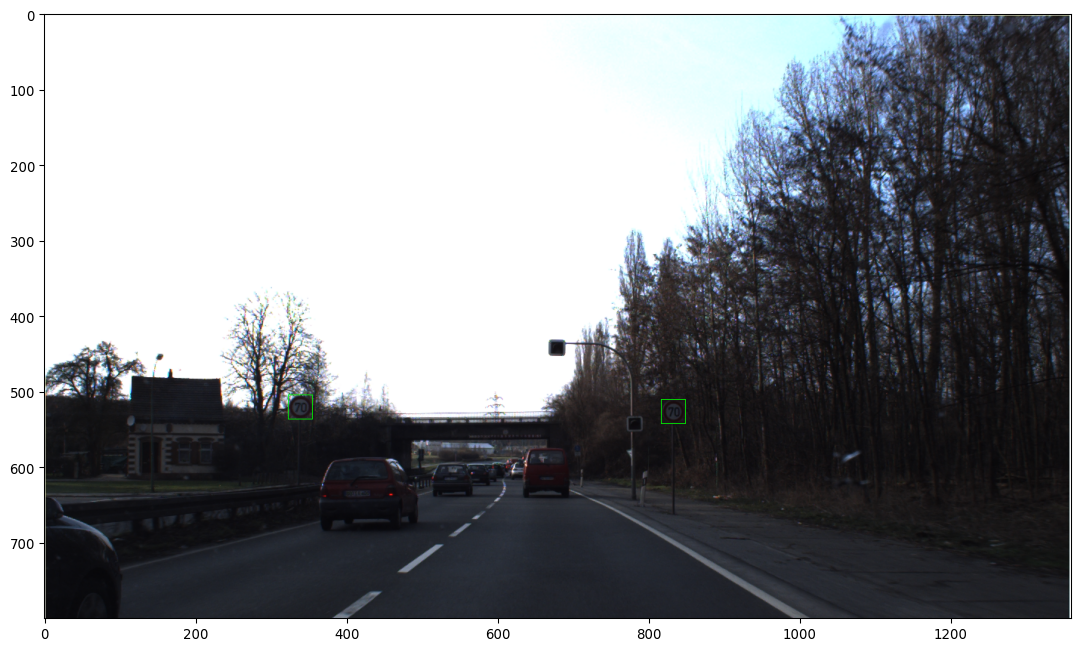

In [15]:
sample_name = "00000_gtsdb00898"
partition_name = "training"
sample_image = SPEED_LIMIT_SIGNS_DATA_DIR / partition_name / "images" / f"{sample_name}.png"
sample_annotation = SPEED_LIMIT_SIGNS_DATA_DIR / partition_name / "annotations" / f"{sample_name}.xml"

bounding_boxes, image = show_image_with_bbox(sample_image, sample_annotation)
ia.imshow(bounding_boxes.draw_on_image(image[..., :3]))

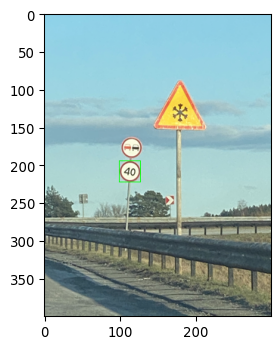

In [16]:
sample_name = "00108_road720"
partition_name = "training"
sample_image = SPEED_LIMIT_SIGNS_DATA_DIR / partition_name / "images" / f"{sample_name}.png"
sample_annotation = SPEED_LIMIT_SIGNS_DATA_DIR / partition_name / "annotations" / f"{sample_name}.xml"

bounding_boxes, image = show_image_with_bbox(sample_image, sample_annotation)
ia.imshow(bounding_boxes.draw_on_image(image[..., :3]))
